# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: Data oversampling in MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# A function that returns a dataset with a specified size

In [2]:
# import dataset (comes with colab!)
dataFull = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')


# now for the function
def makeTheDataset(N,doubleTheData=False):

  # extract labels (number IDs) and remove from data
  labels = dataFull[:N,0]
  data   = dataFull[:N,1:]

  # normalize the data to a range of [0 1]
  dataNorm = data / np.max(data)


  # make an exact copy of ALL the data
  if doubleTheData:
    dataNorm = np.concatenate((dataNorm,dataNorm),axis=0)
    labels   = np.concatenate((labels,labels),axis=0)


  # convert to tensor
  dataT   = torch.tensor( dataNorm ).float()
  labelsT = torch.tensor( labels ).long()

  # use scikitlearn to split the data
  train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, train_size=.9)


  # # make an exact copy of the TRAIN data
  # if doubleTheData:
  #   train_data   = torch.cat((train_data,train_data),axis=0)
  #   train_labels = torch.cat((train_labels,train_labels),axis=0)
  

  # convert into PyTorch Datasets
  train_data = TensorDataset(train_data,train_labels)
  test_data  = TensorDataset(test_data,test_labels)

  # translate into dataloader objects
  batchsize    = 20
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return train_loader,test_loader

In [3]:
# Check the sizes
r,t = makeTheDataset(200,False)
print(r.dataset.tensors[0].shape)
print(t.dataset.tensors[0].shape)

r,t = makeTheDataset(200,True)
print(r.dataset.tensors[0].shape)
print(t.dataset.tensors[0].shape)

torch.Size([180, 784])
torch.Size([20, 784])
torch.Size([360, 784])
torch.Size([40, 784])


# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [5]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Run the model once to confirm that it works

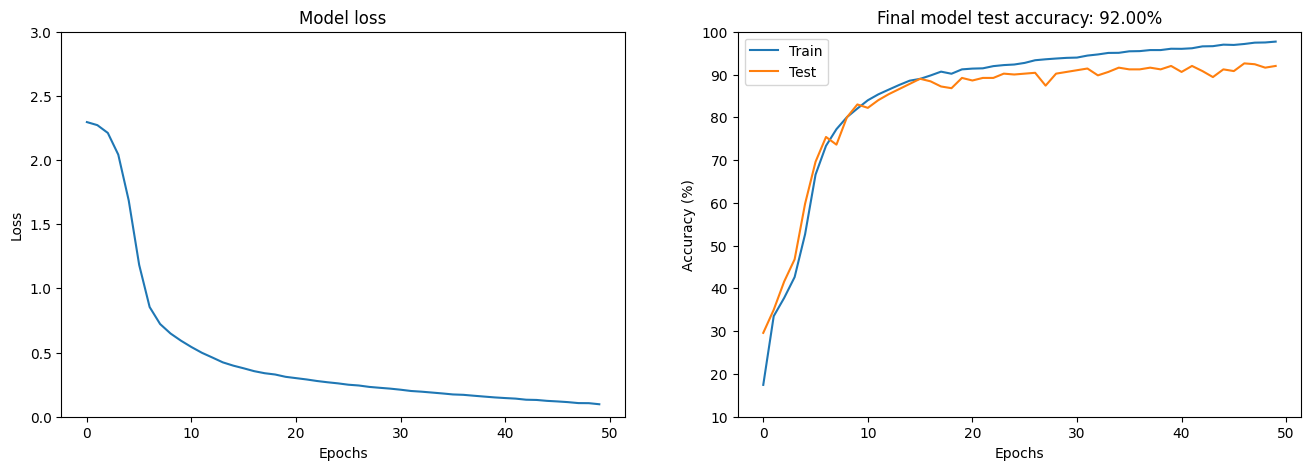

In [6]:
# generate a dataset
train_loader,test_loader = makeTheDataset(5000)

# test it
trainAcc,testAcc,losses,net = function2trainTheModel()



# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Run an experiment showing better performance with increased N



In [7]:
# takes ~3 mins

# list of data sample sizes
samplesizes = np.arange(500,4001,500)

# initialize results matrix
resultsSingle = np.zeros((len(samplesizes),3))
resultsDouble = np.zeros((len(samplesizes),3))


for idx,ssize in enumerate(samplesizes):

  ### without doubling the data!

  # generate a dataset and train the model
  train_loader,test_loader = makeTheDataset(ssize,False)
  trainAcc,testAcc,losses,net = function2trainTheModel()

  # grab the results
  resultsSingle[idx,0] = np.mean(trainAcc[-5:])
  resultsSingle[idx,1] = np.mean(testAcc[-5:])
  resultsSingle[idx,2] = torch.mean(losses[-5:]).item()


  ### with doubling the data!

  # generate a dataset and train the model
  train_loader,test_loader = makeTheDataset(ssize,True)
  trainAcc,testAcc,losses,net = function2trainTheModel()

  # grab the results
  resultsDouble[idx,0] = np.mean(trainAcc[-5:])
  resultsDouble[idx,1] = np.mean(testAcc[-5:])
  resultsDouble[idx,2] = torch.mean(losses[-5:]).item()


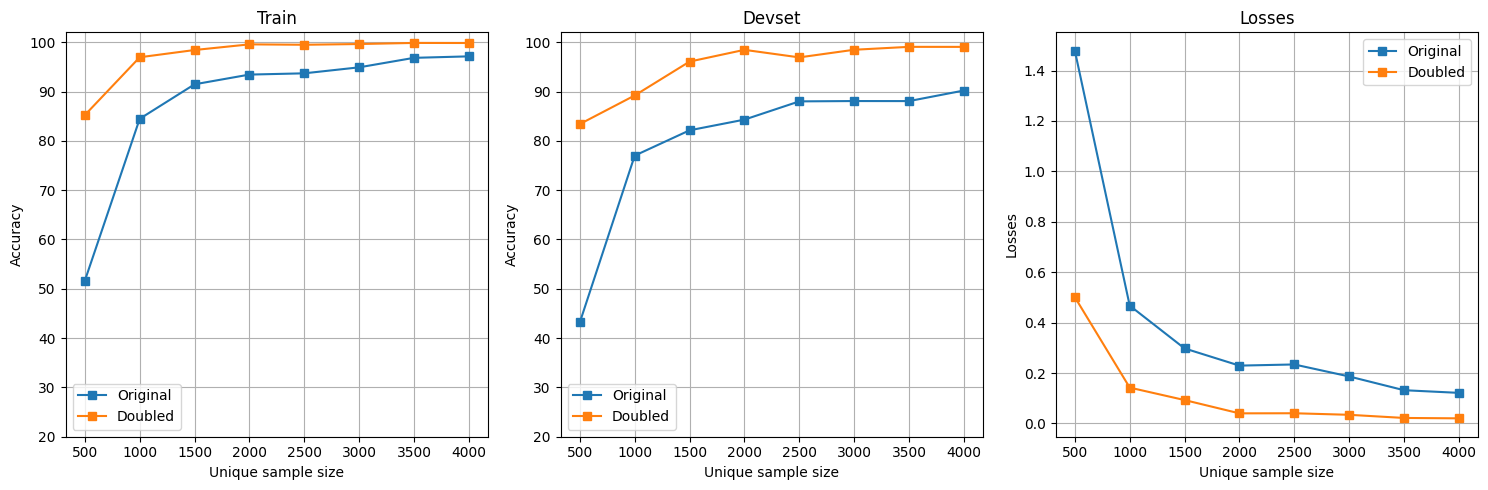

In [8]:
# Let's see what the results look like!

fig,ax = plt.subplots(1,3,figsize=(15,5))

# axis and title labels
titles    = ['Train','Devset','Losses']
yaxlabels = ['Accuracy','Accuracy','Losses']

# common features
for i in range(3):

  # plot the lines
  ax[i].plot(samplesizes,resultsSingle[:,i],'s-',label='Original')
  ax[i].plot(samplesizes,resultsDouble[:,i],'s-',label='Doubled')
  
  # make it look nicer
  ax[i].set_ylabel(yaxlabels[i])
  ax[i].set_title(titles[i])
  ax[i].legend()
  ax[i].set_xlabel('Unique sample size')
  ax[i].grid('on')

  if i<2:
    ax[i].set_ylim([20,102])


plt.tight_layout()
plt.show()

# Additional explorations

In [ ]:
# 1) Notice that we're using the "test_dataset" multiple times, which really means that it's the devset,
#    aka hold-out set, and not a true TEST set. A real test set gets evaluated only once. Modify the code
#    to create a test set, using images in dataFull that are not in dataNorm. Note that you don't need 
#    to re-run the entire experiment; you only need to train two models (and save their 'net' outputs), so that
#    you can run the test data through (make sure to normalize the test data!). Then you can evaluate the test
#    performance relative to train and devset from those two models.
# 
# 2) We've previously discovered that Adam can outperform SGD on the MNIST dataset. I used SGD here on purpose --
#    to make performance worse (!) so we could test for effects of oversampling. Re-run the experiment using
#    Adam to see whether you still get the same effects. 
# 